# Changing Illumination of EGF

In [221]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
from dask.distributed import Client
import xrsignal

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [149]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37727,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:40613,Total threads: 4
Dashboard: http://127.0.0.1:39449/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:42399,


In [13]:
fn = '/datadrive/lfhydrophone/lfhydrophone_spectrogram_median.zarr/'
specs = xr.open_zarr(fn)

specs = specs.rename({'time_frequency':'frequency'})

In [30]:
AXEC2 = specs['AXEC2'].where(~np.isnan(specs['AXEC2']), drop=True)
AXCC1 = specs['AXCC1'].where(~np.isnan(specs['AXCC1']), drop=True)

## SPDFs

In [121]:
bin_edges = np.linspace(10,110,1000)

hists = []
for k in tqdm(range(AXEC2.sizes['frequency'])):
    h,_ = np.histogram(
        AXEC2.isel({'frequency':k}),
        bins=bin_edges,
        density=True)
    hists.append(h)
AXEC2_spdf = np.array(hists)

hists = []
for k in tqdm(range(AXCC1.sizes['frequency'])):
    h,_ = np.histogram(
        AXCC1.isel({'frequency':k}),
        bins=bin_edges,
        density=True)
    hists.append(h)
AXCC1_spdf = np.array(hists)

100%|█████████████████████████████████████████████████████████████████████████████| 513/513 [02:00<00:00,  4.26it/s]


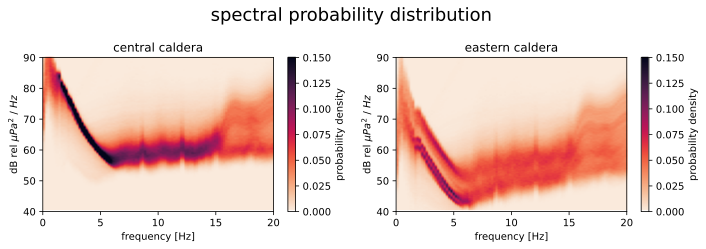

In [139]:
fig,axes = plt.subplots(1,2,figsize=(10,3.5))
fig.suptitle('spectral probability distribution', fontsize=18)

plt.sca(axes[0])
plt.imshow(AXCC1_spdf.T, aspect='auto', cmap='rocket_r', extent=( 0,100, bin_edges[-1], bin_edges[0],), vmax=0.15, rasterized=True)
plt.colorbar(label='probability density')
plt.ylabel('dB rel $\mu Pa^2 \ / \ Hz$')
plt.ylim([40, 90])
plt.xlim([0,20])
plt.xlabel('frequency [Hz]')
plt.title('central caldera')

plt.sca(axes[1])
plt.imshow(AXEC2_spdf.T, aspect='auto', cmap='rocket_r', extent=( 0,100, bin_edges[-1], bin_edges[0],), vmax=0.15, rasterized=True)
plt.colorbar(label='probability density')
plt.ylabel('dB rel $\mu Pa^2 \ / \ Hz$')
plt.ylim([40, 90])
plt.xlim([0,20])
plt.xlabel('frequency [Hz]')
plt.title('eastern caldera')

plt.tight_layout()

fig.savefig('figures/spdf_0_20.svg', dpi=300)

## TDGFS before and after

In [ ]:
# Load NCCFs
fn = '/datadrive/NCCFs/1hr_20150101_20230101_ec_cc_fcs_1_90.nc'
NCCFs = xr.open_dataarray(fn)
time_coord = pd.date_range(pd.Timestamp('2015-01-01'), pd.Timestamp('2022-12-31 t23:59:59.999'), freq='1H')
NCCFs = NCCFs.assign_coords({'time':time_coord})
NCCFs = NCCFs.chunk({'time':100, 'delay':11999})

NCCFs201 = NCCFs.rolling(time=200, min_periods=100).mean().compute()
NCCFs201 = NCCFs201.chunk({'time':100, 'delay':11999})

In [199]:
NCCFs201.load()

<xarray.DataArray 'random_sample-eedc4351b1c3d394b1aa5032d5253f1f' (
                                                                    time: 70128,
                                                                    delay: 11999)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [-1.59597724e-07,  1.24670842e-07,  5.74405220e-08, ...,
        -3.10380347e-07,  1.73271250e-07, -3.38657797e-08],
       [-1.54646766e-07,  1.09677006e-07,  1.08633199e-08, ...,
        -2.75597035e-07,  1.75700742e-07, -3.10544714e-08],
       [-1.64169858e-07,  9.32430377e-08,  2.23936142e-08, ...,
        -3.40256877e-07,  1.42507591e-07, -9.00354068e-09]])
Coordinates:
  * delay    (delay) float64 -30.0 -29.99 -29.99 -29.98 ... 29.98 29.99 29.99
  * time     (time) datetime64[ns] 2015-01-01 ... 2022-12-31T23:00:00

In [159]:
NCCFs_before = NCCFs201.loc[:pd.Timestamp('2019-01-01')].load()
NCCFs_after = NCCFs201.loc[pd.Timestamp('2019-01-01'):pd.Timestamp('2022-01-01')].load()

In [160]:
bin_edges = np.linspace(-0.0144,0.0125,1000)

hists = []
for k in tqdm(range(NCCFs_before.sizes['delay'])):
    h,_ = np.histogram(
        NCCFs_before.isel({'delay':k}),
        bins=bin_edges,
        density=True)
    hists.append(h)
EGF_before_hist = np.array(hists)

hists = []
for k in tqdm(range(NCCFs_after.sizes['delay'])):
    h,_ = np.histogram(
        NCCFs_after.isel({'delay':k}),
        bins=bin_edges,
        density=True)
    hists.append(h)
EGF_after_hist = np.array(hists)

100%|████████████████████████████████████████████████████████████████████████| 11999/11999 [00:22<00:00, 532.03it/s]


(-0.001, 0.003)

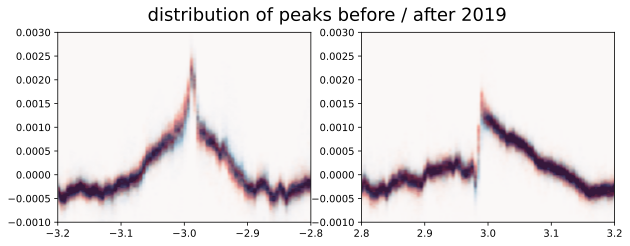

In [195]:
fig,axes = plt.subplots(1,2,figsize=(10,3.5))
fig.suptitle('distribution of peaks before / after 2019', fontsize=18)

plt.sca(axes[0])
plt.imshow(EGF_before_hist.T, aspect='auto', cmap='Blues', extent=(-29.995, 29.995, bin_edges[-1], bin_edges[0]), vmax=2500, alpha=1, zorder=0)
plt.imshow(EGF_after_hist.T, aspect='auto', cmap='Reds', extent=(-29.995, 29.995, bin_edges[-1], bin_edges[0]), vmax=2500, alpha=0.7, zorder=1)
plt.xlim([-3.2,-2.8])
plt.ylim([-0.001, 0.003])

plt.sca(axes[1])
plt.imshow(EGF_before_hist.T, aspect='auto', cmap='Blues', extent=(-29.995, 29.995, bin_edges[-1], bin_edges[0]), vmax=2500, alpha=1, zorder=0)
plt.imshow(EGF_after_hist.T, aspect='auto', cmap='Reds', extent=(-29.995, 29.995, bin_edges[-1], bin_edges[0]), vmax=2500, alpha=0.7, zorder=1)
plt.xlim([2.8, 3.2])
plt.ylim([-0.001, 0.003])


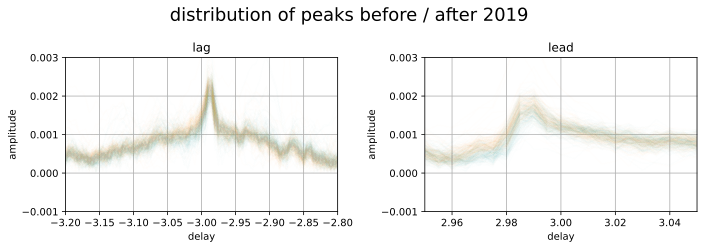

2023-08-21 18:48:21,262 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-08-21 18:48:21,262 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-08-21 18:48:21,262 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-08-21 18:48:21,262 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-08-21 18:48:21,263 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-08-21 18:48:21,263 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-08-21 18:48:21,263 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/home/jhrag/anaconda3/envs/ooi_dev_archive/lib/python3.10/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/jhrag/anaconda3/envs/ooi_dev_archive/lib/python3.10/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/jhrag/anaconda3/envs/ooi_dev_archive/lib/

In [226]:
fig,axes = plt.subplots(1,2,figsize=(10,3.5))
fig.suptitle('distribution of peaks before / after 2019', fontsize=18)

plt.sca(axes[0])
for k in range(174):
    xrsignal.hilbert_mag(NCCFs201[::201].loc[:pd.Timestamp('2019-01-01'),:][k,:], dim='delay').plot(c='C0', alpha=0.01)
    
for k in range(174):
    xrsignal.hilbert_mag(NCCFs201[::201].loc[pd.Timestamp('2019-01-01'):,:][k,:], dim='delay').plot(c='C1', alpha=0.01)
    
plt.xlim([-3.2, -2.8])
plt.ylim([-0.001, 0.003])
plt.grid()
plt.ylabel('amplitude')
plt.title('lag')

plt.sca(axes[1])
for k in range(174):
    xrsignal.hilbert_mag(NCCFs201[::201].loc[:pd.Timestamp('2019-01-01'),:][k,:], dim='delay').plot(c='C0', alpha=0.01)
    
for k in range(174):
    xrsignal.hilbert_mag(NCCFs201[::201].loc[pd.Timestamp('2019-01-01'):,:][k,:], dim='delay').plot(c='C1', alpha=0.01)
    
plt.xlim([2.95, 3.05])
plt.ylim([-0.001, 0.003])
plt.grid()
plt.ylabel('amplitude')
plt.title('lead')

plt.tight_layout()

In [222]:
xrsignal.hilbert_mag(

<module 'xrsignal' from '/home/jhrag/Code/xrsignal/src/xrsignal/__init__.py'>